In [13]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [14]:
import tsfresh

In [15]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
sns.set_context('poster')

In [17]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [18]:
df = pd.read_pickle('CCPA.pkl.gz')

In [19]:
dfw = df.loc[(df.experiment.isin(['e1', 'e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [20]:
#dfw = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) # & (df.culture == 'Co_Culture')
#            ]

In [223]:
dfdecline = cp.generate_decline(dfw, scale=False)
dfdecline = dfdecline.loc[dfdecline['day'] <= 80]

In [224]:
n = 'exponential'
f = cp.model_exponential
t = dfdecline.groupby('experiment_sample').apply(lambda x: cp.apply_fit(x, f, print_popt=False))
dfdecline[n] = t['y_pred']
for i in range(3):
    dfdecline[f'popt_{i}'] = t[f'popt_{i}']
dfdecline['decline'] = dfdecline.FL
dfdecline['exponential_diff'] = dfdecline.FL - dfdecline.exponential
dfdecline['decline_scaled'] = dfdecline.groupby('experiment_sample').FL.transform(lambda x: x / x.max())


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.


In [225]:
dfdecline.columns


Index(['experiment_sample', 'day', 'FL', 'experiment', 'sample', 'PRO', 'ALT',
       'culture', 'exponential', 'popt_0', 'popt_1', 'popt_2', 'decline',
       'exponential_diff', 'decline_scaled'],
      dtype='object')

In [159]:
dfdecline40 = dfdecline.loc[dfdecline.day < 41]

In [243]:
#dfdecline.drop()
df_exp = dfdecline.groupby(['experiment_sample','popt_0', 'popt_1', 'popt_2'])['decline'].count().reset_index(level=[1,2,3])\
.drop(columns='decline')

In [234]:
dfdecline.head()

,experiment_sample,day,FL,experiment,sample,PRO,ALT,culture,exponential,popt_0,popt_1,popt_2,decline,exponential_diff,decline_scaled
0,"e1, 10A",0.000000,5.621,e1,10A,C9B,DE,Co_Culture,5.271426,4.777059,0.269209,0.494367,5.621,0.349574,1.000000
1,"e1, 10A",0.893056,4.045,e1,10A,C9B,DE,Co_Culture,4.250563,4.777059,0.269209,0.494367,4.045,-0.205563,0.719623
2,"e1, 10A",1.991667,2.749,e1,10A,C9B,DE,Co_Culture,3.288861,4.777059,0.269209,0.494367,2.749,-0.539861,0.489059
3,"e1, 10A",4.697222,2.924,e1,10A,C9B,DE,Co_Culture,1.843270,4.777059,0.269209,0.494367,2.924,1.080730,0.520192
4,"e1, 10A",5.700000,2.519,e1,10A,C9B,DE,Co_Culture,1.524137,4.777059,0.269209,0.494367,2.519,0.994863,0.448141


# Compare Models

def compare_models(df, value_col, resample_period_list, y_col_list, cumsummode_list, 
                   repetitions=10, return_y=False):
    # resample first
    stats_list = []
    y_list= []
    clf_list = []
    features_list = []
    for resample_period in resample_period_list:
        if resample_period is not None:
            d = cp.resample_df(df, value_col=value_col, period=resample_period)
        else:
            d = df
        metadf = cp.get_meta(d, value_col=value_col)
        for cumsummode in cumsummode_list:
            #print(resample_period, value_col, cumsummode)
            X = cp.experiments2X(d, value_col=value_col, cumsummode=cumsummode)
            
            resample_str = '_' + resample_period if resample_period is not None else ''
            cumsummode_str = '_cumsum' if cumsummode else ''
            for y_col in y_col_list:
                modelname = f'{y_col}_{value_col}{resample_str}{cumsummode_str}'
                for i in range(repetitions):
                    clf, res, calc_y = cp.ml(X=X, metadf=metadf, modelname=modelname, 
                                        y_col=y_col, return_y=return_y)
                    res['value_col'] = value_col
                    res['resample_period'] = resample_period
                    res['y_col'] = y_col
                    res['cumsum'] = cumsummode
                    stats_list.append(res)
                    y_list.append(calc_y)
                    clf_list.append(clf)
                    features_list.append(X.columns)
                
    return stats_list, y_list, clf_list, features_list
            

def compare_models_features(df, y_col_list, repetitions=10):
    # resample first
    stats_list = []
    metadf = cp.get_meta(df, meta_col=['experiment_sample', 'experiment',
                                       'sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
    X = cp.features2X(df)
    for y_col in y_col_list:
        modelname = f'{y_col}_features'
        for i in range(repetitions):
            clf, res, _ = cp.ml(X=X, metadf=metadf, modelname=modelname, y_col=y_col)
            res['value_col'] = 'features'
            res['resample_period'] = 'N/A'
            res['y_col'] = y_col
            res['cumsum'] = False
            stats_list.append(res)
    return stats_list

def compare_models_ts_features(df, metadf, y_col_list, mode='', repetitions=10):
    # resample first
    stats_list = []
    X = df
    for y_col in y_col_list:
        modelname = f'{y_col}_ts_features{mode}'
        for i in range(repetitions):
            clf, res, _ = cp.ml(X=X, metadf=metadf, modelname=modelname, y_col=y_col)
            res['value_col'] = f'ts_features{mode}'
            res['resample_period'] = 'N/A'
            res['y_col'] = y_col
            res['cumsum'] = False
            stats_list.append(res)
    return stats_list


In [260]:
clf, res, _ = cp.ml(X=df_exp, metadf=cp.get_meta(dfdecline), modelname='exponential_coef', y_col='PRO')
res

exponential_coef
train score 0.9100719424460432


{'model': 'exponential_coef',
 'n_features': 3,
 'orig_n_features': 3,
 'accuracy_train': 0.9100719424460432,
 'precision_train': 0.9129747706851241,
 'recall_train': 0.9100719424460432,
 'f1_train': 0.9095657505001313,
 'support_train': None,
 'accuracy_test': 0.46153846153846156,
 'precision_test': 0.4184981684981685,
 'recall_test': 0.46153846153846156,
 'f1_test': 0.43115080829703994,
 'support_test': None}

In [261]:
clf, res, _ = cp.ml(X=df_exp, metadf=cp.get_meta(dfdecline), modelname='exponential_coef', y_col='ALT')
res

exponential_coef
train score 0.9100719424460432


{'model': 'exponential_coef',
 'n_features': 3,
 'orig_n_features': 3,
 'accuracy_train': 0.9100719424460432,
 'precision_train': 0.9111928022279568,
 'recall_train': 0.9100719424460432,
 'f1_train': 0.9102953156469744,
 'support_train': None,
 'accuracy_test': 0.3384615384615385,
 'precision_test': 0.3417049617049617,
 'recall_test': 0.3384615384615385,
 'f1_test': 0.3280751308337515,
 'support_test': None}

In [27]:
# compare models based on different experiment features
# value_col, 

decline_col_list = ['exponential', 'decline', 'exponential_diff', 'decline_scaled']
resample_period_list = [None, '1d', '3d', '5d']
y_col_list = ['PRO', 'ALT', 'PRO_ALT', 'ALT_PRO']
cumsummode_list = [False, True]

In [255]:
# compare models based on different experiment features
# value_col, 
decline_col_list = ['decline']
resample_period_list = ['1d']
y_col_list = ['PRO_ALT']
y_col_list = ['PRO']
cumsummode_list = [False]

In [256]:
repetitions=1

In [257]:
stats_list = []
y_list = []
clf_list = []
features_list = []
for i in decline_col_list:
    res, _y_list, _clf_list, _features_list = cp.compare_models(dfdecline, value_col=i, 
               resample_period_list=resample_period_list, 
               y_col_list=y_col_list, 
               cumsummode_list=cumsummode_list,
               repetitions=repetitions,
                                            return_y=True)
    stats_list.extend(res)
    y_list.extend(_y_list)
    clf_list.extend(_clf_list)
    features_list.extend(_features_list)


PRO_decline_1d
train score 1.0


In [258]:
#stats_list = []
#y_list = []
#clf_list = []
features_list = []
dfdecline40['decline40'] = dfdecline40['decline']
for i in ['decline40']:
    res, _y_list, _clf_list, _features_list = cp.compare_models(dfdecline40, value_col=i, 
               resample_period_list=resample_period_list, 
               y_col_list=y_col_list, 
               cumsummode_list=cumsummode_list,
               repetitions=repetitions,
                                            return_y=True)
    stats_list.extend(res)
    y_list.extend(_y_list)
    clf_list.extend(_clf_list)
    features_list.extend(_features_list)


PRO_decline40_1d
train score 1.0


In [207]:
y_df = y_list[0]


In [208]:
clf = clf_list[0]

In [209]:
stats_df = pd.DataFrame.from_records(stats_list)

In [210]:
stats_df.fillna({'resample_period' : 'N/A'}, inplace=True)

In [211]:
stats_df

,accuracy_test,accuracy_train,cumsum,f1_test,f1_train,model,precision_test,precision_train,recall_test,recall_train,resample_period,support_test,support_train,value_col,y_col
0,0.661538,1.0,False,0.663289,1.0,PRO_decline_1d,0.744256,1.0,0.661538,1.0,1d,None,None,decline,PRO


In [212]:
clf.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1, 14,  1,  5,  7,  6,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 12,  3, 11, 10,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, 13,  9,  1])

In [49]:
d = cp.resample_df(dfdecline, value_col='decline', period='1d')

In [53]:
d.day = d.day.astype('timedelta64[D]')


C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


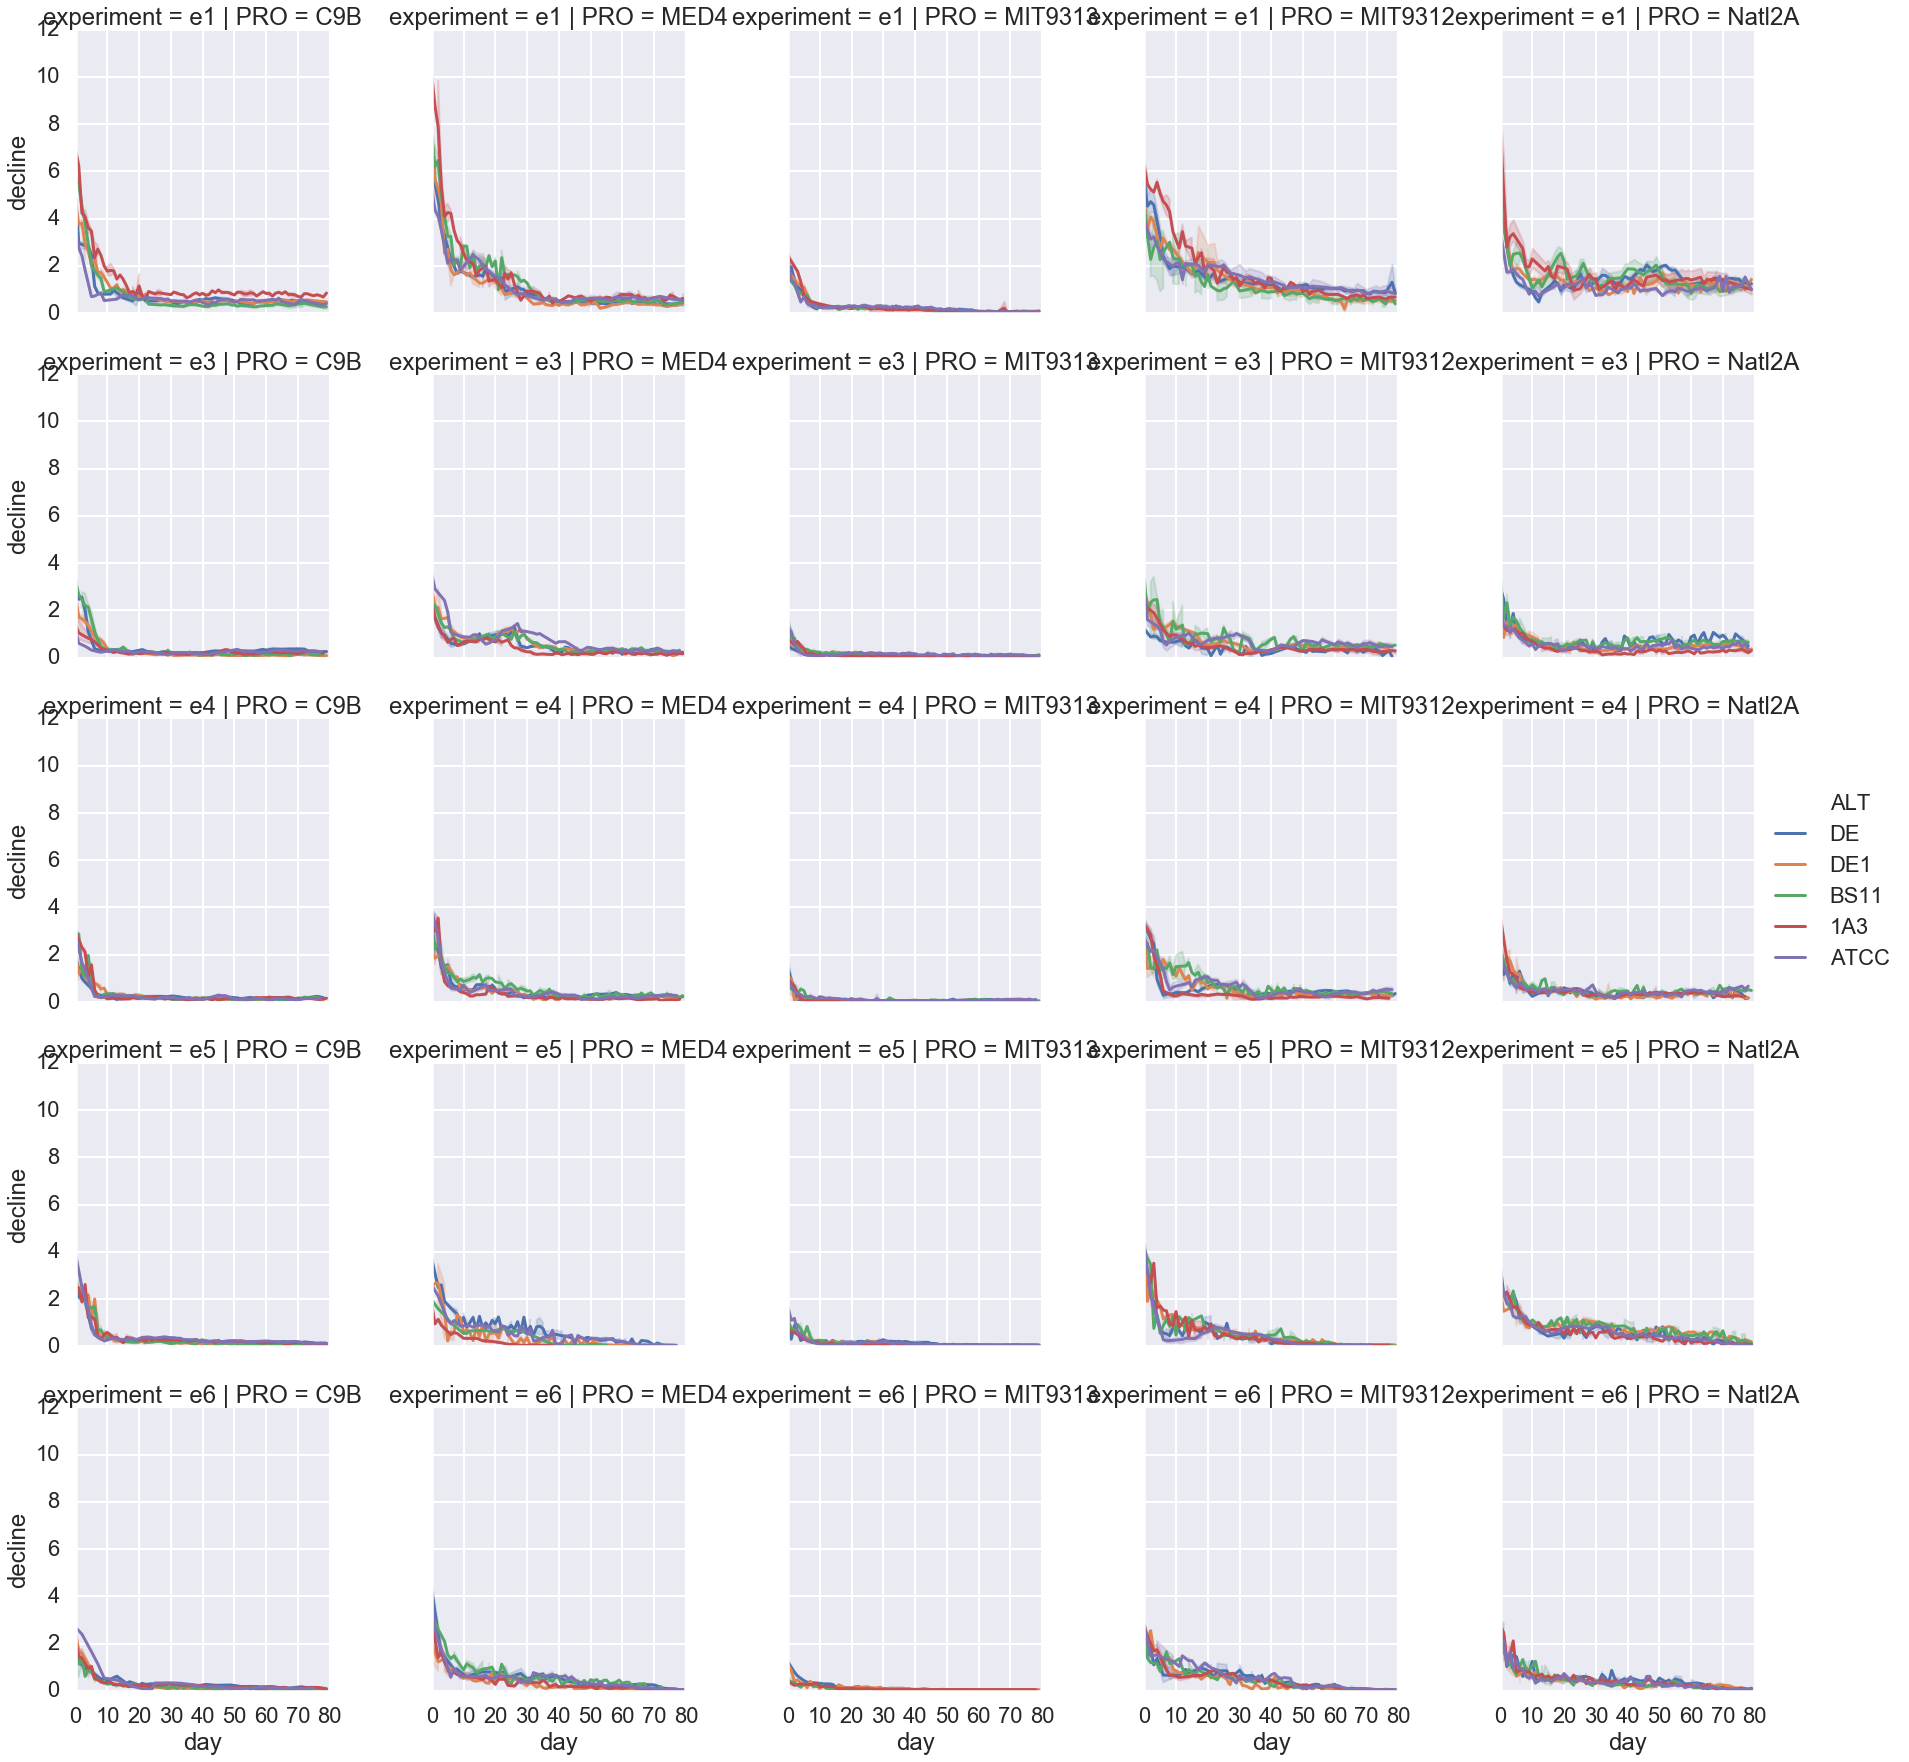

In [60]:
sns.relplot(data=d, x='day', y='decline', kind='line',
           col='PRO', row='experiment', hue='ALT')

In [61]:
y_df.head()

,PRO_ALT_decline_1d_y,PRO_ALT_decline_1d_y_PRO,PRO_ALT_decline_1d_y_pred,PRO_ALT_decline_1d_y_pred_PRO,Type
experiment_sample,,,,,
"e1, 10A",C9B,C9B,"C9B,DE",C9B,Train
"e1, 10B",C9B,C9B,"C9B,DE",C9B,Train
"e1, 10C",C9B,C9B,"C9B,DE",C9B,Train
"e1, 11A",MED4,MED4,"MED4,DE1",MED4,Train
"e1, 11B",MED4,MED4,"MED4,DE1",MED4,Train


In [62]:
X = cp.experiments2X(d, value_col='decline', cumsummode=False)


In [64]:
X.columns.shape

(80,)

In [215]:
    feature_importances = pd.DataFrame(clf.estimator_.feature_importances_,
                                       index = features_list[0][clf.support_],
                                        columns=['importance'])


In [216]:
d1 = d.merge(feature_importances, how='left', left_on='day', right_index=True)
d1.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,decline,importance
0,"e1, 10A",e1,10A,C9B,DE,Co_Culture,0.0,4.833,0.020519
1,"e1, 10A",e1,10A,C9B,DE,Co_Culture,1.0,2.749,0.015169
4,"e1, 10A",e1,10A,C9B,DE,Co_Culture,4.0,2.924,0.017346
5,"e1, 10A",e1,10A,C9B,DE,Co_Culture,5.0,2.519,0.017218
6,"e1, 10A",e1,10A,C9B,DE,Co_Culture,6.0,1.169,0.007296


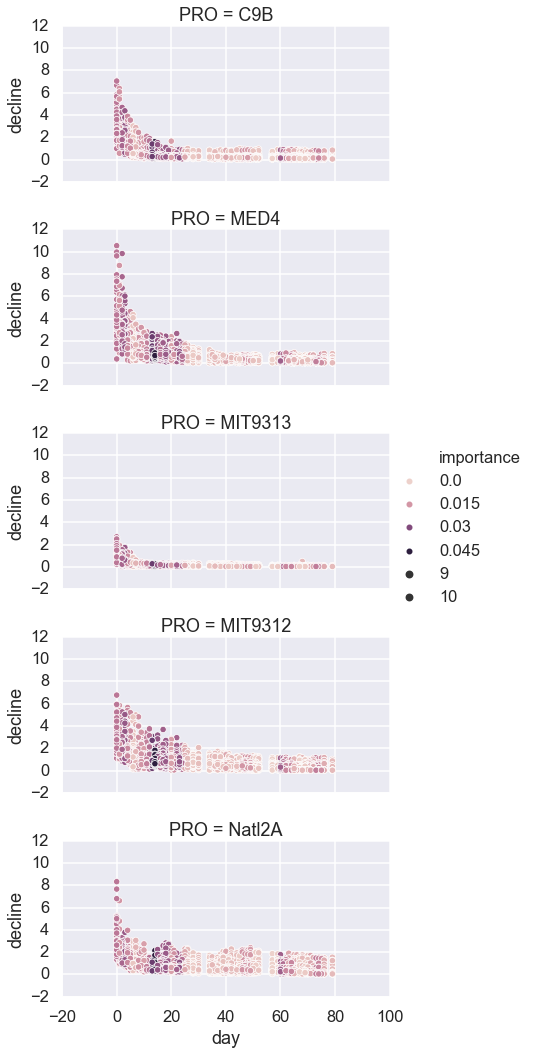

In [217]:

sns.relplot(data=d1, x='day', y='decline', 
            #kind='line',
           row='PRO', #col='ALT',
            #row='experiment', #
            hue='importance',
            aspect=2, height=3,
            #sizes=(3,3),
            size=10,
           )

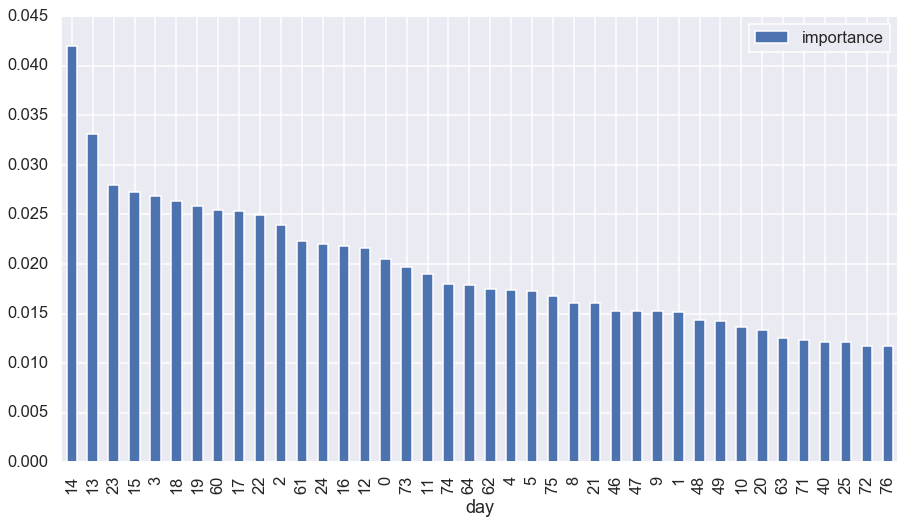

In [218]:
feature_importances.nlargest(columns='importance', n=40).plot(kind="bar")

In [219]:
y_df.head()

,PRO_decline_1d_y,PRO_decline_1d_y_PRO,PRO_decline_1d_y_pred,PRO_decline_1d_y_pred_PRO,Type
experiment_sample,,,,,
"e1, 10A",C9B,C9B,C9B,C9B,Train
"e1, 10B",C9B,C9B,C9B,C9B,Train
"e1, 10C",C9B,C9B,C9B,C9B,Train
"e1, 11A",MED4,MED4,MED4,MED4,Train
"e1, 11B",MED4,MED4,MED4,MED4,Train


In [115]:
y_df.columns

Index(['PRO_ALT_decline_1d_y', 'PRO_ALT_decline_1d_y_PRO',
       'PRO_ALT_decline_1d_y_pred', 'PRO_ALT_decline_1d_y_pred_PRO', 'Type'],
      dtype='object')

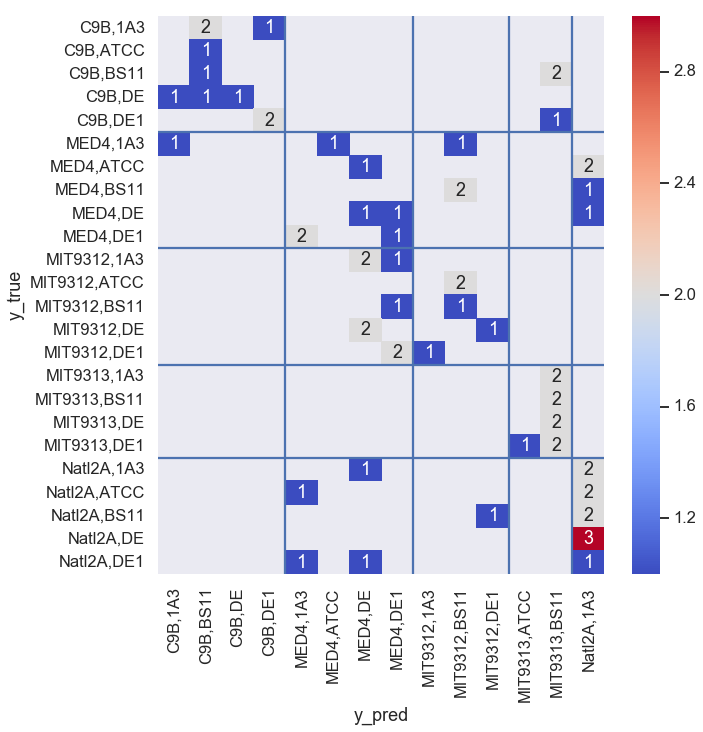

In [149]:
sns.set_context('talk')
from sklearn.metrics import classification_report
#y_df['x'] = 1
t= y_df.loc[y_df.Type == 'Test', ['PRO_ALT_decline_1d_y', 'PRO_ALT_decline_1d_y_pred']]
t.columns = ['y_true', 'y_pred']
t['x'] =1
t1 = t.pivot_table(index='y_true', columns=['y_pred'], aggfunc='count')
t1.columns = t1.columns.get_level_values(1)
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(t1, annot=True, cmap='coolwarm', ax=ax,
                 #, square=True
                 yticklabels=True, xticklabels=True
                 
                )
ax.axhline(5)
ax.axhline(10)
ax.axhline(15)
ax.axhline(19)
ax.axvline(4)
ax.axvline(8)
ax.axvline(11)
ax.axvline(13)

#print(f"accuracy: {accuracy_score(y_true=d['actual'], y_pred=d['predicted'])}")
#print(classification_report(y_true=y_df.loc[y_df.Type == 'Test'].PRO_ALT_decline_1d_y_PRO, 
#                            y_pred=y_df.loc[y_df.Type == 'Test'].PRO_ALT_decline_1d_y_pred_PRO))

              precision    recall  f1-score   support

         C9B       1.00      0.62      0.76        13
        MED4       0.50      0.80      0.62        15
     MIT9312       0.55      0.46      0.50        13
     MIT9313       0.64      1.00      0.78         9
      Natl2A       1.00      0.53      0.70        15

   micro avg       0.66      0.66      0.66        65
   macro avg       0.74      0.68      0.67        65
weighted avg       0.74      0.66      0.66        65



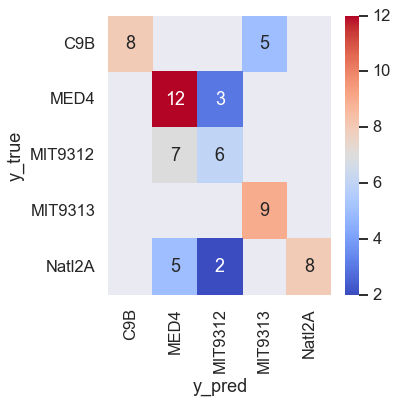

In [221]:
    from sklearn.metrics import classification_report
    #y_df['x'] = 1
    t= y_df.loc[y_df.Type == 'Test', ['PRO_decline_1d_y_PRO', 'PRO_decline_1d_y_pred_PRO']]
    t.columns = ['y_true', 'y_pred']
    t['x'] =1
    t1 = t.pivot_table(index='y_true', columns=['y_pred'], aggfunc='count')
    t1.columns = t1.columns.get_level_values(1)
    fig, ax = plt.subplots(figsize=(5,5)) 
    sns.heatmap(t1, annot=True, cmap='coolwarm', ax=ax)

    #print(f"accuracy: {accuracy_score(y_true=d['actual'], y_pred=d['predicted'])}")
    print(classification_report(y_true=t.y_true, y_pred=t.y_pred))

In [222]:
clf.estimator_.n_features_

67

In [198]:
t = dfdecline.groupby(['experiment_sample', 'experiment','PRO', 'ALT']).count().groupby(['experiment','PRO','ALT']).FL.count()
t[t <3]

experiment  PRO      ALT 
e1          C9B      ATCC    1
e3          C9B      ATCC    1
            MED4     ATCC    1
                     BS11    2
            Natl2A   DE      2
e4          C9B      ATCC    1
            MIT9313  1A3     2
e5          C9B      ATCC    1
                     BS11    2
            MED4     1A3     1
                     ATCC    2
                     BS11    1
            MIT9312  ATCC    2
                     DE1     2
            MIT9313  1A3     2
e6          C9B      ATCC    1
            MIT9312  ATCC    2
                     BS11    2
            MIT9313  1A3     2
                     BS11    2
                     DE      2
Name: FL, dtype: int64

In [203]:
t = dfw.groupby(['experiment_sample', 'PRO', 'ALT']).count().groupby(['PRO','ALT']).FL.count()
t[t<10]

PRO  ALT 
C9B  ATCC    5
Name: FL, dtype: int64

In [254]:
X.columns.shape[0]

80